In [1]:
from copy import copy
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
import matplotlib.patches as pat
from IPython import display
import matplotlib
from tqdm.notebook import tqdm, trange
import random
random.seed = 0
matplotlib.rcParams['animation.ffmpeg_path'] = r"C:\\Users\\GidoVerheijen\\Documents\\Studie\\Natural Computing\\ffmpeg-2023-03-20-git-57afccc0ef-essentials_build\\bin\\ffmpeg.exe"
#matplotlib.rcParams['animation.ffmpeg_path'] = r"C:\Users\stanv\Documents\Radboud University\2223 Natural Computing (KW3 V)\Activities\Assignments\Project report\ffmpeg-2023-05-22-git-877ccaf776-full_build\ffmpeg-2023-05-22-git-877ccaf776-full_build\bin\ffmpeg.exe"

In [2]:
import numpy as np
from copy import copy

def run_parallel(operation, input, pool):
    return pool.map(operation, input)


class Board:
    def __init__(self, size, number_of_holes, number_of_coins, wumpus_path=None):
        """
        Initializes the Board class.
        
        Args:
        - size: A tuple representing the size of the board.
        - number_of_wumpus: The number of wumpus entities on the board.
        - number_of_holes: The number of holes on the board.
        - number_of_coins: The number of coins on the board.
        - wumpus_path: Optional parameter representing the path for the wumpus entities to move along.
        """
        self.size = size
        self.number_of_wumpus = 1
        self.number_of_holes = number_of_holes
        self.number_of_coins = number_of_coins
        self.wumpus_path = wumpus_path
        self.coin_locs = []
        self.__create_board__()
        self.initial_board = np.copy(self.board)
        if wumpus_path is not None:
            self.initial_wumpus_path = np.copy(wumpus_path)
        else:
            self.initial_wumpus_path = None

    def __create_board__(self):
        """
        Creates the board with the specified entities (wumpus, holes, and coins) at random positions.
        """
        rng = np.random.default_rng()
        ids = rng.choice(self.size[0] * self.size[1] - 1, size=self.number_of_wumpus + self.number_of_holes + self.number_of_coins, replace=False)
        ids = np.array(ids) + 1
        self.board = np.array([["." for i in range(self.size[1])] for j in range(self.size[0])], dtype='<U200')
        ids = [[i // self.size[1], i % self.size[1]] for i in ids]
        for i in range(self.number_of_wumpus + self.number_of_holes + self.number_of_coins):
            if i < 1:
                self.board[ids[i][0], ids[i][1]] = 'W'
                self.wumpus = Wumpus(self, ids[i])
            elif i < self.number_of_holes + self.number_of_wumpus:
                self.board[ids[i][0], ids[i][1]] = 'H'
            else:
                self.board[ids[i][0], ids[i][1]] = 'C'
                self.coin_locs.append([ids[i][0], ids[i][1]])
        
    def scorefield(self, coins):
        score_field = np.zeros_like(self.initial_board, dtype = 'float64')
        x, y = np.indices((score_field.shape[0], score_field.shape[1])).astype('float64')
        for c_loc in coins:
            s = 20/((x - c_loc[0])**2 + (y - c_loc[1])**2 + 1)
            score_field = np.maximum(score_field, s)
        if len(coins) == 0:
            s = 20/(x**2 + y**2)
            score_field = s
        return score_field
        
        
        
    def _bounds(self, pos):
        """
        Checks if the given position is within the bounds of the board and adjusts it if necessary.

        Args:
        - pos: A list representing the position [x, y].

        Returns:
        The adjusted position within the bounds of the board.
        """
        for i in range(2):
            if pos[i] >= self.size[i]:
                pos[i] = self.size[i] - 1
            if pos[i] < 0:
                pos[i] = 0
        return pos

    def _display(self, board):
        """
        Displays the board.

        Args:
        - board: A numpy array representing the board.
        """
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                print(board[i, j] + "\t", end='')
            print("")

    def display(self):
        """
        Displays the current state of the board.
        """
        self._display(self.initial_board)
    
    def check_path(self, path, animate=False):
        agent_pos = [0,0]
        dead = False
        coins = 0
        finished = False
        performed_steps = 0
        walk_score = 0
        old_position_score = 0
        
        wumpus_direction = None
        wumpus_interval = 1
        self.wumpus.pos = np.copy(self.wumpus.start_pos)
        wumpus_pos = np.copy(self.wumpus.start_pos)
        coins_pos = list(np.copy(self.coin_locs))
        if self.initial_wumpus_path is not None:
            self.wumpus_path = list(np.copy(self.initial_wumpus_path))
        else:
            self.wumpus_path = list(np.random.randint(0, 3, len(path)))
        self.board = np.copy(self.initial_board)
        
        if animate:
            b_show = [np.copy(self.board)]
            b_show[0][agent_pos[0], agent_pos[1]] = 'A'
        
        
        for n,i in enumerate(path):
            if not dead and not finished:
                performed_steps += 1
                prev_a_pos = np.copy(agent_pos)
                prev_w_pos = np.copy(wumpus_pos)
                
                if (n+1)%wumpus_interval == 0:
                    if self.wumpus_path is not None:
                        wumpus_direction = self.wumpus_path.pop(0)
                        self.wumpus_path.append(wumpus_direction)
                    wumpus_pos = self.move_wumpus(wumpus_direction)
                new_pos = self.get_new_position(agent_pos, i)
                agent_pos = self._bounds(new_pos)
                
                
                
                new_position_score = self.scorefield(coins_pos)[agent_pos[0], agent_pos[1]]
                #print(new_position_score)
                if old_position_score != 20:
                    if new_position_score > old_position_score:
                        if new_position_score == 20:
                            walk_score += 2
                        else:
                            walk_score += 1
                    elif new_position_score < old_position_score:
                        walk_score -= 1
                old_position_score = new_position_score
                
                if animate:
                    b_show.append(np.copy(b_show[n]))
                    b_show[n + 1][prev_a_pos[0], prev_a_pos[1]] = '.'
                    b_show[n + 1][prev_w_pos[0], prev_w_pos[1]] = '.'
                    b_show[n + 1][agent_pos[0], agent_pos[1]] = 'A'
                    b_show[n + 1][wumpus_pos[0], wumpus_pos[1]] = 'W'
                
                if self.board[agent_pos[0], agent_pos[1]] == 'C':
                    self.board[agent_pos[0], agent_pos[1]] = '.'
                    d = []
                    for i in range(len(coins_pos)):
                        if coins_pos[i][0] != agent_pos[0] or coins_pos[i][1] != agent_pos[1]:
                            d.append(coins_pos[i])
                    coin_pos = d
                    coins += 1
                elif self.board[agent_pos[0], agent_pos[1]] == 'H' or self.board[agent_pos[0], agent_pos[1]] == 'W':
                    dead = True
                elif agent_pos == [0, 0] and (n > len(path) / 2 or coins == self.number_of_coins):  # prev_pos != [0,0]:
                    finished = True
        if animate:
            if dead:
                m = np.array([['W' for i in self.board[0]] for j in self.board])
                b_show.append(m)
            elif finished:
                m = np.array([['A' for i in self.board[0]] for j in self.board])
                b_show.append(m)
            return b_show
        else:
            return dead, coins, finished, performed_steps, walk_score
    
    def get_new_position(self, pos, direction):
        """
        Calculates the new position based on the current position and direction.

        Args:
        - pos: A list representing the current position [x, y].
        - direction: An integer representing the direction to move (0: up, 1: right, 2: down, 3: left, 4: stand still).

        Returns:
        The new position after moving in the specified direction.
        """
        new_pos = pos
        if direction == 0:
            new_pos[0] -= 1
        elif direction == 1:
            new_pos[1] += 1
        elif direction == 2:
            new_pos[0] += 1
        elif direction == 3:
            new_pos[1] -= 1
        return new_pos

    def is_valid_wumpus_position(self, pos):
        """
        Checks if the given position is a valid position for a wumpus entity.

        Args:
        - pos: A list representing the position [x, y].

        Returns:
        A boolean indicating whether the position is a valid wumpus position.
        """
        x, y = pos
        if 0 <= x < self.size[0] and 0 <= y < self.size[1] and (x, y) != (0, 0):
            entity = self.board[x, y]
            return entity not in ['H', 'C']
        return False

    def move_wumpus(self, direction=None):
        """
        Moves the wumpus entity in the specified direction.

        Args:
        - direction: An integer representing the direction to move (0: up, 1: right, 2: down, 3: left, 4: stand still).
                     If None, the wumpus entity moves randomly.

        Returns:
        The new position of the wumpus entity after moving.
        """
        
        if direction is not None:
            return self.wumpus.move_along_path(self, direction)
        else:
            return self.wumpus.move_randomly(self)


In [3]:
class Agent:
    def __init__(self, board, path_length = None, path = None):
        """
        Initializes an Agent object.

        Args:
        - board: The Board object representing the game board.
        - path_length: An integer indicating the length of the agent's path.
        - path: A list of integers of value [0,1,2,3,4] indicating the path of the agents
        """
        self.board = board
        if path is not None:
            self.path = path
            self.path_length = path_length
        else:
            self.path = np.empty(0)
            self.path_length = path_length
            self.fitness = 0
            self._initialize_path()
        self.fitness = 0
        
    def fitness_function(self):
        """
        Calculates the fitness value for the agent based on its path.

        The fitness value is determined by the number of coins collected, whether the agent
        is dead, and whether the agent has finished the game.

        Returns:
        None. Updates the fitness attribute of the agent.
        """
        dead, coins, finished, steps, walk_points = self.board.check_path(self.path)
        fit = 100 * coins
        fit -= steps*1
        #print("walk", walk_points)
        fit += walk_points
        if dead:
            fit -= 1000
        if finished:
            fit += 50
        self.fitness = fit
        
    def _initialize_path(self):
        directions = [0, 1, 2, 3, 4]
        weights = [0.225, 0.225, 0.225, 0.225, 0.1]
        direction = random.choices(directions, weights)[0]
        self.path = np.append(self.path, direction)
        for i in range(0, self.path_length - 1):
            if direction == 0:
                weights = [0.35, 0.225, 0.1, 0.225, 0.1]
            elif direction == 1:
                weights = [0.225, 0.35, 0.225, 0.35, 0.1]
            elif direction == 2:
                weights = [0.1, 0.225, 0.35, 0.225, 0.1]
            elif direction == 3:
                weights = [0.225, 0.1, 0.225, 0.35, 0.1]
            direction = random.choices(directions, weights)[0]
            self.path = np.append(self.path, direction)


In [17]:
class Population:
    def __init__(self, board, number, max_steps, mutation_rate, single_mutate = True):
        """
        Initializes a Population object.

        Args:
        - board: The Board object representing the game board.
        - number: An integer representing the population size.
        - max_steps: An integer indicating the maximum number of steps in an agent's path.
        - mutation_rate: A float indicating the mutation rate for agents.
        - single_mutate: A boolean indicating whether there can only be a single mutation per gene. 
        """
        self.population_size = number
        self.board = board
        self.mu = mutation_rate
        self.max_steps = max_steps
        self.single_mutate = single_mutate
        self.population = [Agent(board, random.randint(1, max_steps)) for i in range(number)]
        self.population_fitness = np.array([0 for i in range(number)])
        self.fitness()
        
    def fitness(self):
        """
        Calculates the fitness values for all agents in the population.

        Returns:
        None. Updates the population_fitness attribute of the population.
        """
        
        for n, i in enumerate(self.population):
            i.fitness_function()
            self.population_fitness[n] = i.fitness
        
    
    def _tournament_selection(self, group, n):
        """
        Performs tournament selection for parent agents.

        Args:
        - group: The population group on which the tournament selection will be ran. 
        - n: An integer indicating the number of agents to select in each tournament.

        Returns:
        - ids: A list of agent IDs selected through tournament selection.
        - rem: A list of agent IDs that will be removed. 
        """
        #print(group)
        sort = np.argsort(-1*group)
        #print(sort)
        ids = sort[:n]        
        rem = sort[n:]
            
        return ids, rem
    
    def double_crossover(self, n):
        """
        Performs double crossover to create a new population.
        
        Args:
        - n: An integer indicating the number of agents that are part of the tournament selection
        
        Returns:
        None. Updates the population attribute of the population.
        """
        
        group_ids = np.array(random.sample(range(self.population_size), n))
        group = np.array(self.population_fitness)[group_ids]
        ids, rem = self._tournament_selection(group, 2)
        agent1 = self.population[ids[0]]
        agent2 = self.population[ids[1]]
        
        #print(np.max(np.array(self.population_fitness)[group_ids[rem]]))
        #print(sorted(self.population_fitness[group_ids], reverse = True))
        for i in sorted(group_ids[rem], reverse = True):
            self.population.pop(i)
        
        
        for i in range(n//2 - 1):
 
            cut1 = np.sort(np.random.randint(0, len(agent1.path), 2))
            cut2 = np.sort(np.random.randint(0, len(agent1.path), 2))
            child1_path = np.concatenate((agent1.path[:cut1[0]], agent2.path[cut1[0]:cut1[1]], agent1.path[cut1[1]:]))
            child2_path = np.concatenate((agent2.path[:cut2[0]], agent1.path[cut2[0]:cut2[1]], agent2.path[cut2[1]:]))
            child1 = Agent(self.board,path = child1_path)
            child2 = Agent(self.board,path = child2_path)
            child1, child2 = self.mutate([child1, child2], self.single_mutate)
            
            self.population.append(child1)
            self.population.append(child2)
        assert len(self.population) == self.population_size
    
    def mutate(self, group, single_mutate = True):
        """
        Mutates the paths of agents in the population based on the mutation rate.
        
        Args:
        - group: A list of agents to which the mutation function will be applied. 
        - single_mutate: A boolean stating whether there is only a single mutation, or there can be more. 
        
        Returns:
        group: The updated list of agents. 
        """
        for agent in group:
            if single_mutate:
                mutation = np.random.rand() < self.mu

                if mutation:
                    length = len(agent.path)
                    if length > 1:
                        p1 = np.random.randint(0, length-1)
                        newmove = np.random.randint(0, 4)
                        agent.path[p1] = newmove
            else:
                length = len(agent.path)
                for i in range(length):
                    if np.random.rand() < self.mu:
                        agent.path[i] = np.random.randint(0,4)
                
        return group
            
    def natural_selection(self, iterations, plot=False):
        """
        Performs natural selection for a specified number of iterations.

        Args:
        - iterations: An integer indicating the number of iterations to perform.
        - plot: A boolean indicating whether to plot the fitness values over iterations.

        Returns:
        A list containing the best fitness value at each iteration.
        """
        best_fitness = [np.max(self.population_fitness)]
        average_fitness = [np.average(self.population_fitness)]
        average_length = [np.average([len(i.path) for i in self.population])]
        pbar = trange(iterations)
        for i in pbar:
            pbar.desc = (f"Best: {best_fitness[i]:.2f}, Avg: {average_fitness[i]:.2f}, Avg_path: {average_length[i]}")
            #print(i)
            self.double_crossover(self.population_size // 5)
            #self.population = [Agent(self.board, self.max_steps) for i in range(self.population_size)]
            self.fitness()
            best_fitness.append(np.max(self.population_fitness))
            average_fitness.append(np.average(self.population_fitness))
            average_length.append(np.average([len(i.path) for i in self.population]))
            if plot:
                plt.figure()
                plt.hist(p.population_fitness, bins=2*coins)
                plt.yscale('log')
                plt.show()
        return best_fitness, average_fitness, average_length


In [18]:
class Wumpus:
    def __init__(self, board, pos):
        """
        Initializes a Wumpus object.

        Args:
        - board: The Board object representing the game board.
        - pos: A tuple representing the initial position of the Wumpus.
        """
        self.board = board
        self.pos = pos
        self.start_pos = pos
        
    def move_along_path(self, board, direction):
        """
        Moves the Wumpus along a given direction on the board.

        Args:
        - board: The Board object representing the game board.
        - direction: An integer representing the direction to move (0: up, 1: right, 2: down, 3: left).

        Returns:
        The new position of the Wumpus after moving.
        """
        new_pos = self.board.get_new_position(self.pos.copy(), direction)
        if self.board.is_valid_wumpus_position(new_pos):
            board.board[self.pos[0], self.pos[1]] = '.'
            self.pos = new_pos
            board.board[self.pos[0], self.pos[1]] = 'W'
        return self.pos
                
    def move_randomly(self, board):
        """
        Moves the Wumpus randomly on the board.

        Args:
        - board: The Board object representing the game board.

        Returns:
        The new position of the Wumpus after moving.
        """
        valid_directions = []
        for direction in range(4):
            new_pos = self.board.get_new_position(self.pos.copy(), direction)
            if self.board.is_valid_wumpus_position(new_pos):
                valid_directions.append(direction)
        if valid_directions:
            
            direction = random.choice(valid_directions)
            new_pos = self.board.get_new_position(self.pos.copy(), direction)
            board.board[self.pos[0], self.pos[1]] = '.'
            self.pos = new_pos
            board.board[self.pos[0], self.pos[1]] = 'W'
        return self.pos


In [28]:
def board_plot(board, ax):
    """
    Plot the game board.

    Args:
    - board: A 2D array representing the game board.
    - ax: The Axes object to plot on.
    """
    x, y = np.shape(board)
    for i in range(x + 1):
        plt.plot([i, i], [0, y], c='black')
    for i in range(y + 1):
        plt.plot([0, x], [i, i], c='black')

    for i in range(x):
        for j in range(y):
            if board[i, j] == 'W':
                ax.add_patch(pat.Circle((i + 0.5, j + 0.5), 0.5, fc='red'))
            elif board[i, j] == 'C':
                ax.add_patch(pat.Circle((i + 0.5, j + 0.5), 0.5, fc='yellow'))
            elif board[i, j] == 'A':
                ax.add_patch(pat.Circle((i + 0.5, j + 0.5), 0.5, color='blue'))
            elif board[i, j] == 'H':
                ax.add_patch(pat.Circle((i + 0.5, j + 0.5), 0.5, fc='black'))

def boards_to_animation(boards):
    """
    Convert a series of game boards into an animation.

    Args:
    - boards: A 3D array representing a sequence of game boards.

    Returns:
    None
    """
    def animate(board):
        ax.clear()
        board_plot(board, ax)

    fig, ax = plt.subplots(figsize=(5, 5))
    frames, x, y = np.shape(boards)
    anim = animation.FuncAnimation(fig, animate, frames=boards, interval=1000)
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

    
def experiment(size, holes, coins, path):
    b = Board(size, holes, coins, path)
    fig, ax = plt.subplots(1,1, figsize = (5,5))
    board_plot(b.board, ax)
    plt.show()
    p = Population(b, size[0]*100, size[0]*size[1]*2, 0.01, False)
    best_fitnesses, average_fitnesses, average_path_length = p.natural_selection(1000, False)

    path = p.population[np.argmax(p.population_fitness)].path
    print("Path length: ", len(path))
    print("Fitness Score: ", np.max(p.population_fitness))
    frames = b.check_path(path, animate = True)
    boards_to_animation(frames)
    plt.show()
    plt.plot(range(len(best_fitnesses)), best_fitnesses, label = 'Max Fitness')

    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.legend()

    plt.figure()
    plt.plot(range(len(average_fitnesses)), average_fitnesses, label = 'Average Fitness')
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(range(len(average_path_length)), average_path_length, label = 'Average Path Length')
    plt.xlabel('Iterations')
    plt.ylabel('Path Length')
    plt.legend()
    plt.show()
    return np.max(p.population_fitness)

def run_experiments(size, holes, coins, path):
    results = []
    for i in range(10):
        results.append(experiment(size, holes, coins, path))
    return results



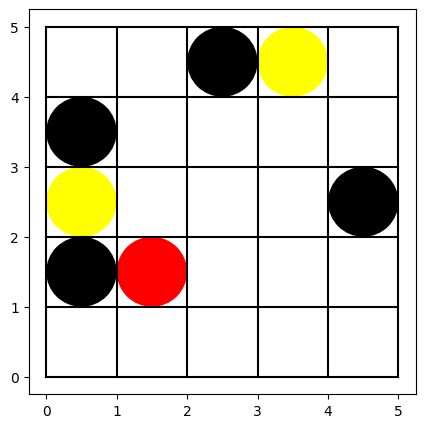

  0%|          | 0/1000 [00:00<?, ?it/s]

Path length:  19
Fitness Score:  193


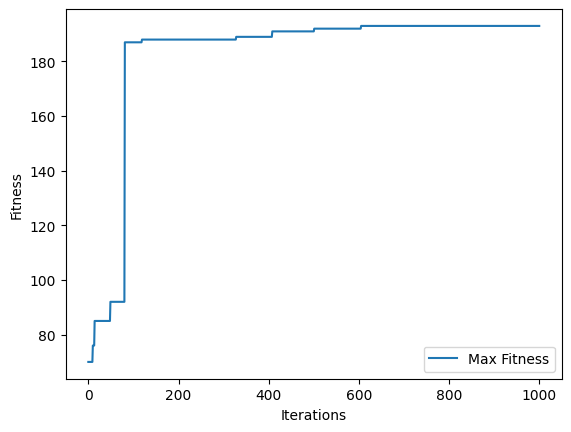

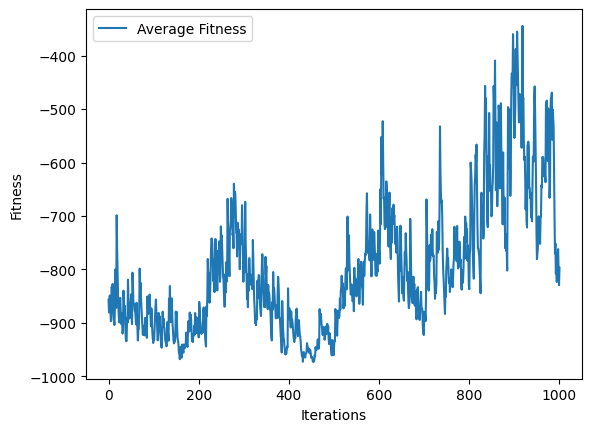

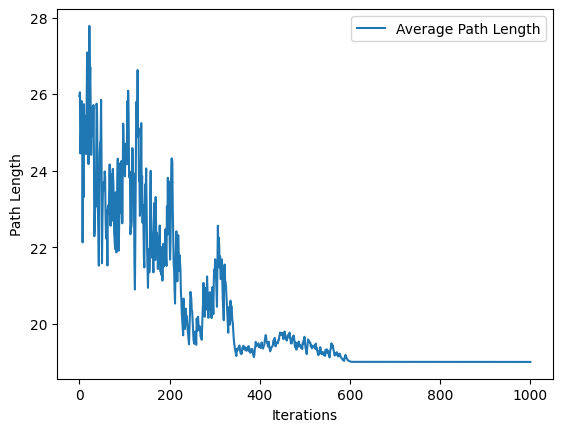

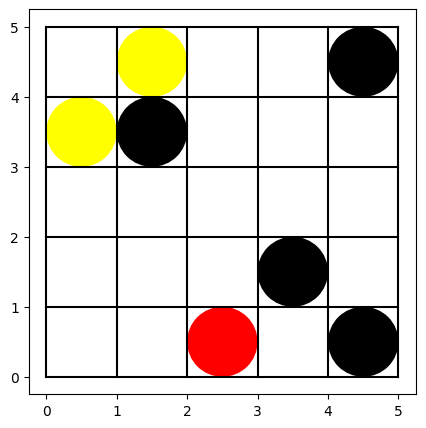

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
results_5x5_left_right = run_experiments((5,5), 4,2, [0,0,0,0,2,2,2,2])


In [ ]:
results_5x5_up_down = run_experiments((5,5), 2,2, [1,1,1,1,3,3,3,3])

In [ ]:
results_5x5_rotation = run_experiment((5,5), 2, 2, [0,0,1,1,2,2,3,3])


In [ ]:
results_10x10_left_right = run_experiments((10,10), 5,5, [0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2])

In [ ]:
results_10x10_up_down = run_experiments((10,10), 5,5, [1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3])

In [ ]:
results_10x10_rotation = run_experiment((5,5), 2, 2, [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3])

[0, 0, 0, 0, 0, 2, 2, 2, 2, 2]


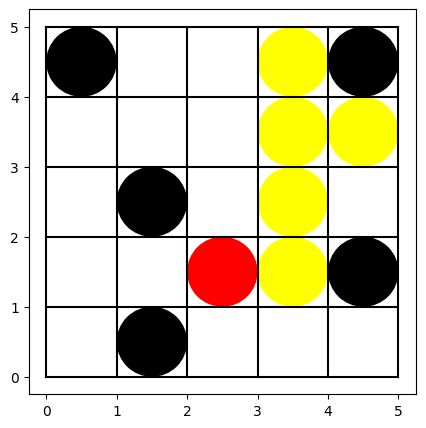

In [7]:

holes = 2
coins = 2
size = (10,10)


path = [0,0,0,0,0, 2,2,2,2,2]#np.random.randint(0, 4, 15)
print(path)
b = Board(size, holes, coins, path)
fig, ax = plt.subplots(1,1, figsize = (5,5))
board_plot(b.board, ax)
plt.show()

In [8]:
p = Population(b, 1000, 500, 0.01, False)
y, z = p.natural_selection(1000, False)

path = p.population[np.argmax(p.population_fitness)].path
print(len(path))
print("Fitness Score: ", np.max(p.population_fitness))
frames = b.check_path(path, animate = True)
#print(frames)
boards_to_animation(frames)
plt.show()
plt.plot(range(len(y)), y, label = 'Max Fitness')

plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()

plt.figure()
plt.plot(range(len(z)), z, label = 'Average Fitness')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()
plt.show()




  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
path = p.population[np.argmax(p.population_fitness)].path
print(path)
print(len(path))
print("Fitness Score: ", np.max(p.population_fitness))
frames = b.check_path(path, animate = True)
#print(frames)
boards_to_animation(frames)
plt.show()


[1. 3. 1. 3. 2. 0. 2. 1. 2. 2. 3. 1. 1. 1. 3. 1. 2. 3. 2. 4. 1.]
21
Fitness Score:  395
